# Practice - SAR Linear Regression

## Spatially Adjusted Regression - Linear Regression

Ordinary Least Squares vs Spatial Simultaneous Autoregressive Models

It is assumed that we are working under the normal probability model. The goals of this practice are to: a) evaluate a standard OLS regression using a continuous dependant variable when spatial autocorrelation may be present and b) evaluate the same relationships given the ability to adjust for spatial autocorrelation using the rho term obtained from a simultaneous autoregressive error model.

In [1]:
# Load relevant R packages
inLibraries = list('repr','rgdal','spdep','classInt','car','RColorBrewer','MASS','geoR')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
“no DISPLAY variable so Tk is not available”

In [2]:
#Read in the featureclass
inFeatures <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields


## Subset Features

As agricultural conditions vary considerably over the U.S., let's select a specific state to analyze - California.

Note, that state names are not explicitly included in the dataset. However, the FIPS code for each county is provided. Typically, the first two digits of a Fips code reflect the state id number while the last three reflect a specific county within a state. For more on fips codes see http://www.nws.noaa.gov/mirs/public/prods/maps/cnty_fips_def.htm. In this dataset, the 'atlas_stco' field contains the fips code as a character variable. Thus, in order to select the first two characters associated with a particular state, we need some way to match one portion of a string to another. There are several ways to do this. In this case, first a new field is added to the dataframe 'stcode' and populated with the first two characters in the 'atlas_stco' field which is the fips code. Next, grep() is used to select the fips code prefixes which correspond with the fips code of California ('06').

In [4]:
#add new column to dataframe and populate with first two numbers of fips code
inFeatures@data$stcode <- substr(inFeatures@data$atlas_stco, 
                                             start = 1, 
                                             stop = 2)

In [5]:
head(inFeatures@data$stcode)

[1] "01" "01" "01" "01" "01" "01"

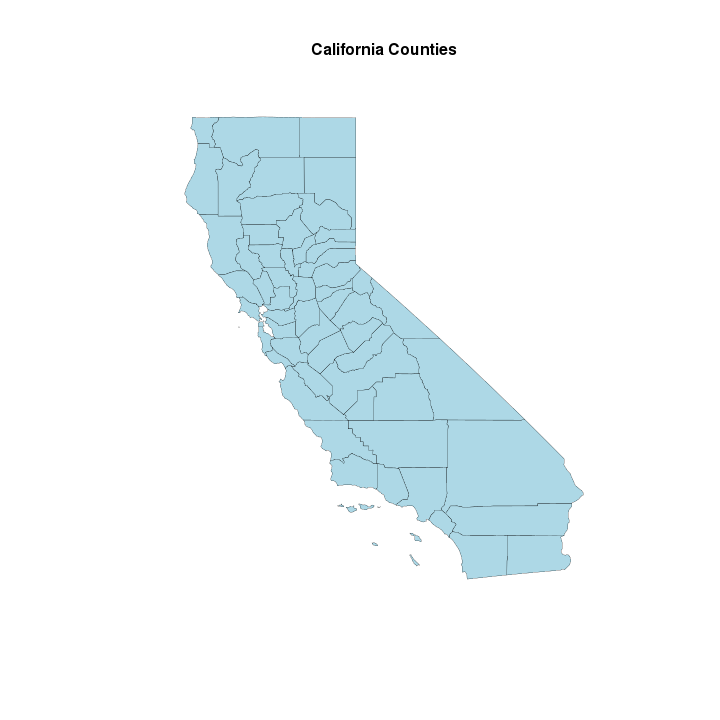

In [6]:
#select features with a state fips code beginning with...
inFeaturesSubsetA <- inFeatures[grep("06", inFeatures@data$stcode), ]

#plot the state selected
plot(inFeaturesSubsetA,col="lightblue", lwd=.2, main="California Counties",cex.main=.8)

## Generate Neighborhoods for Features

Generate neighborhoods for each feature according to the Queen's Criterion.  Then test the neighborhoods to see if they are valid.  Retain only the features with valid neighborhoods.

In [8]:
#Identify the neighbors of each feature
inFeaturesSubsetA.nb <- poly2nb(inFeaturesSubsetA, queen = TRUE)

#Select features with at least one neighbor
inFeaturesSubset <- inFeaturesSubsetA[card(inFeaturesSubsetA.nb) >= 1, ]

#Identify the neighbors of each feature having at least one neighbor
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

#Retrieve neighborhood list
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb,style="B")
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb,style="W")

## Analysis Variables

Configure Variables to Analyze. In this practice, the dependent variable is 'y12_M082_1' (acres of irrigated land as percent of land in farms acreage (year 2012)) and the explainatory varible will be 'GRIDCODE' (mean annual rainfall 1990-2009). 

In [9]:
#percent farmland acres that are irrigated
inVa <- inFeaturesSubset$y12_M082_1

#response variables
YVar <- inVa

#explanatory variable
EXVar <- inFeaturesSubset$GRIDCODE

## Examine Characteristics of Variables

Produce a scatterplot of the dependent variable (y-axis) and the explanatory variable (x-axis). What can be observed? Well, it seems that there is some trend manifesting here. The Shapiro test however indicates the dependent variable is likely not normal as the null hypothesis can be rejected. Although that's not a huge concern at this point, the dependant variable can be transformed to make it more linear.


	Shapiro-Wilk normality test

data:  YVar
W = 0.91452, p-value = 0.0005848


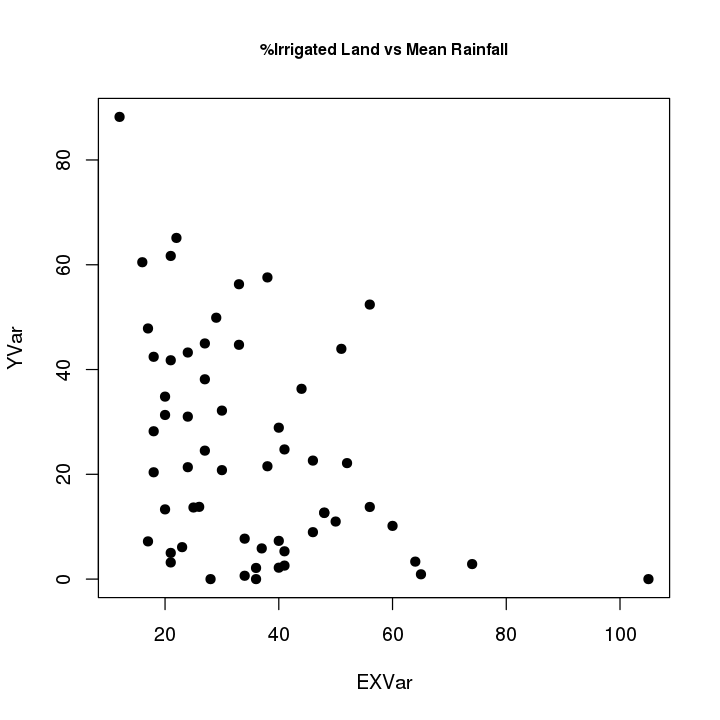

In [10]:
#scatter plot of model variables
plot(EXVar,YVar,pch=19,main="%Irrigated Land vs Mean Rainfall", cex.main=.8)

#conduct a shapiro test
shapiro.test(YVar)

### Transform the Dependent Variable

Here, the dependent variable is powered to adjust the distribution.

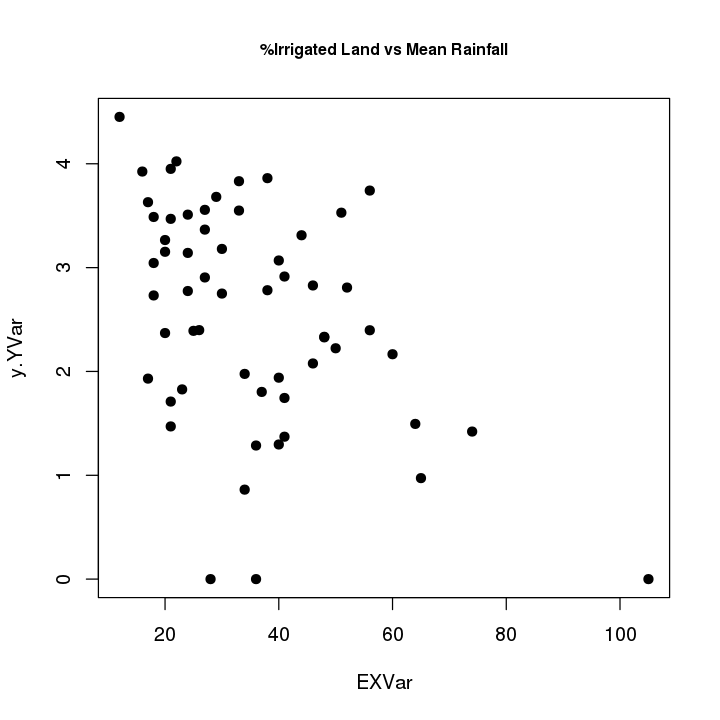

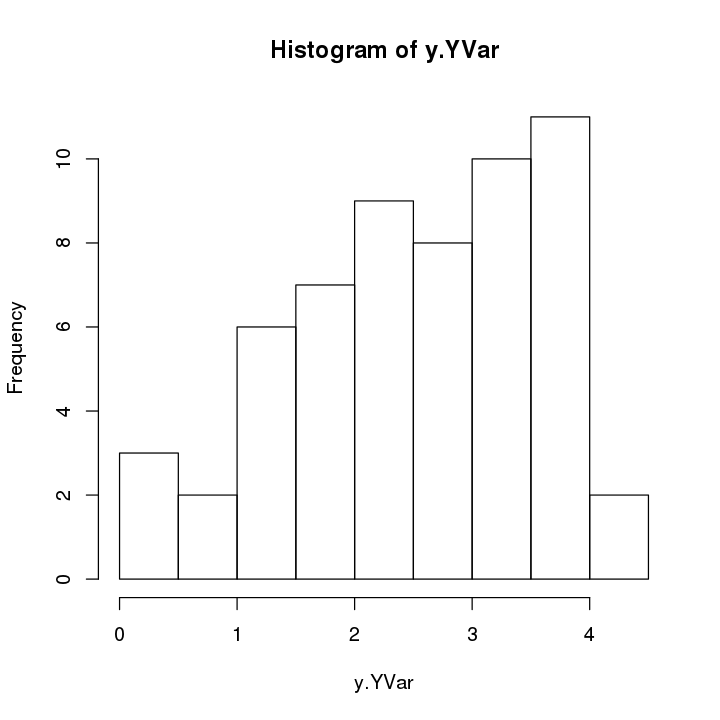

In [11]:
#power transformation applied
lambdapwr <- (1/3)
y.YVar <- YVar^(lambdapwr)

#scatterplot of model variables
plot(EXVar, y.YVar, pch=19, main="%Irrigated Land vs Mean Rainfall", cex.main=.8)

#histogram of dependent variable
hist(y.YVar)

### Shapiro Test

Test the dependant variable again and produce a Q-Q plot.  This time it looks like the null hypothesis is not as easily rejected.


	Shapiro-Wilk normality test

data:  y.YVar
W = 0.95843, p-value = 0.04502



	Shapiro-Wilk normality test

data:  EXVar
W = 0.8873, p-value = 6.127e-05


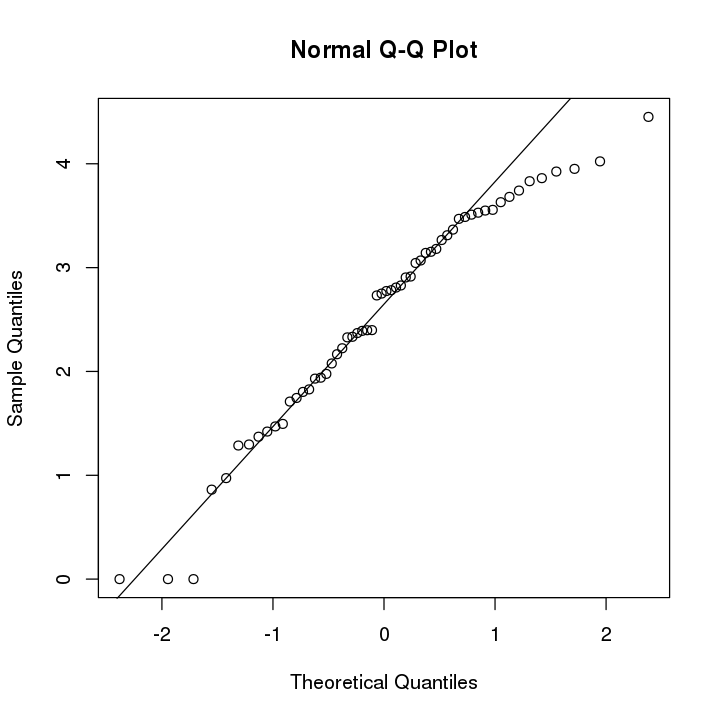

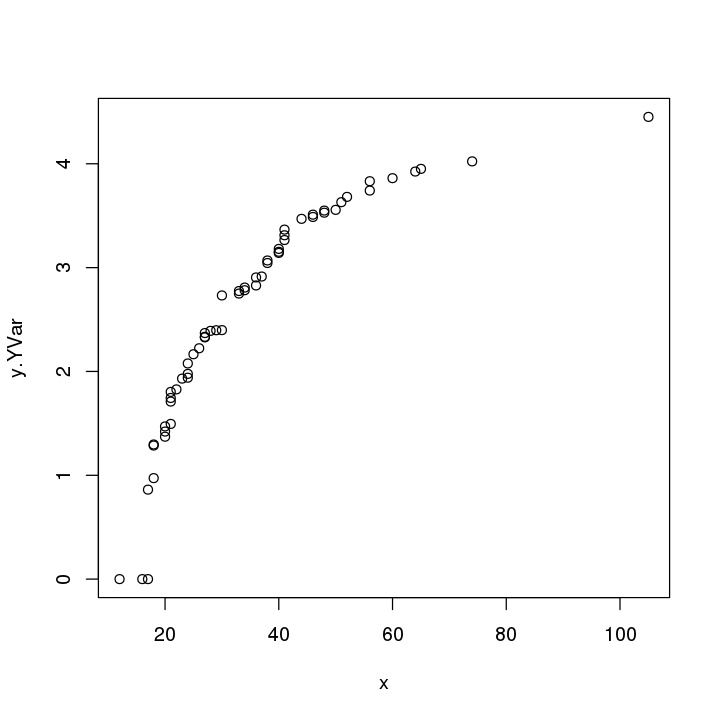

In [12]:
#shapiro test
shapiro.test(y.YVar)
shapiro.test(EXVar)

## Default S3 method:
qqnorm(y.YVar, main = "Normal Q-Q Plot",
       xlab = "Theoretical Quantiles", ylab = "Sample Quantiles",
       plot.it = TRUE, datax = FALSE)

qqline(y.YVar, datax = FALSE)

qqplot(EXVar, y.YVar, plot.it = TRUE, xlab = deparse(substitute(x)),
       ylab = deparse(substitute(y.YVar)))

# Normal Probability Models

## Regular (OLS) Regression

Let's first conduct a OLS linear regression.  Remember, OLS can be called using R's lm() function.  After the function is applied, the resid() function can be called to retrieve the modeled residuals.  Looks like normality can be accepted

In [13]:
#simple OLS
YVar.lm <- lm(y.YVar ~ EXVar)

#ols summary
summary(YVar.lm)

#shapiro test
shapiro.test(resid(YVar.lm))


Call:
lm(formula = y.YVar ~ EXVar)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7598 -0.6102  0.1329  0.6231  1.7687 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.54627    0.29149  12.166  < 2e-16 ***
EXVar       -0.02809    0.00744  -3.775 0.000388 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9515 on 56 degrees of freedom
Multiple R-squared:  0.2029,	Adjusted R-squared:  0.1886 
F-statistic: 14.25 on 1 and 56 DF,  p-value: 0.0003884



	Shapiro-Wilk normality test

data:  resid(YVar.lm)
W = 0.96393, p-value = 0.0823


### Test Residuals for Autocorrelation

Next, test the residuals for presence of spatial autocorrelation.  Perhaps there is some autocorrelation at work in the residuals. If that's the case, then the assumptions of OLS have been violated.

In [14]:
#retrieve residuals
YVar.lm.res <- residuals(YVar.lm)

#apply Moran test
moran.test(YVar.lm.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.lm.res  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 2.5702, p-value = 0.005082
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.189049102      -0.017543860       0.006460929 


## Spatial Simultaneous Autoregressive (SAR) Model

The SAR specification builds upon the OLS specification in that it accounts for the spatial weights among the features (row standardized - W) as an explanatory variable and estimates a coefficient for spatial autocorrelation (rho). The errorsarlm() function (spdep library) can be applied to specify a SAR model. It requires the dependent and independant variables as well as the neighborhood list (listw).  Conduct the SAR analysis below.  Are there any indications of positive spatial autocorrelation?  Does the SAR model improve upon the amount of variance that is accounted for? How can you tell?

Note that the standard errors in the OLS specification are lower than in the SAR specification. This shows that not accounting for spatial autocorrelation makes the OLS results falsely appear to be stronger than they really are!

Finally, let's examine normality of the residuals. There is still an indication of non-normality, but not as extreme as before.

In [15]:
#SAR model
YVar.sar1 <- errorsarlm(y.YVar ~ EXVar, listw=inFeaturesSubset.listw)

#summary of sar model
summary(YVar.sar1)

#obtain the model residuals
YVar.sar1.res <- residuals(YVar.sar1)

#conduct the shapiro test
shapiro.test(YVar.sar1.res)


Call:errorsarlm(formula = y.YVar ~ EXVar, listw = inFeaturesSubset.listw)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.44819 -0.45288  0.13189  0.68786  1.46157 

Type: error 
Coefficients: (asymptotic standard errors) 
              Estimate Std. Error z value  Pr(>|z|)
(Intercept)  3.5417207  0.3750139  9.4442 < 2.2e-16
EXVar       -0.0296463  0.0090148 -3.2886  0.001007

Lambda: 0.41038, LR test value: 4.8867, p-value: 0.027065
Asymptotic standard error: 0.15291
    z-value: 2.6838, p-value: 0.0072788
Wald statistic: 7.2029, p-value: 0.0072788

Log likelihood: -75.95474 for error model
ML residual variance (sigma squared): 0.77119, (sigma: 0.87817)
Number of observations: 58 
Number of parameters estimated: 4 
AIC: 159.91, (AIC for lm: 162.8)



	Shapiro-Wilk normality test

data:  YVar.sar1.res
W = 0.95575, p-value = 0.03364


### Test Residuals for Autocorrelation

Test the SAR residuals for presence of spatial autocorrelation.  How does this result differ from the Moran test applied to the OLS residuals?

In [16]:
#apply moran test to SAR residuals
moran.test(YVar.sar1.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.sar1.res  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 0.4955, p-value = 0.3101
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.022392807      -0.017543860       0.006496026 


### Plot the Fitted Values (SAR) Model

Plot the fitted SAR values, being sure that the values are backtransformed into their original measurement units prior to mapping.

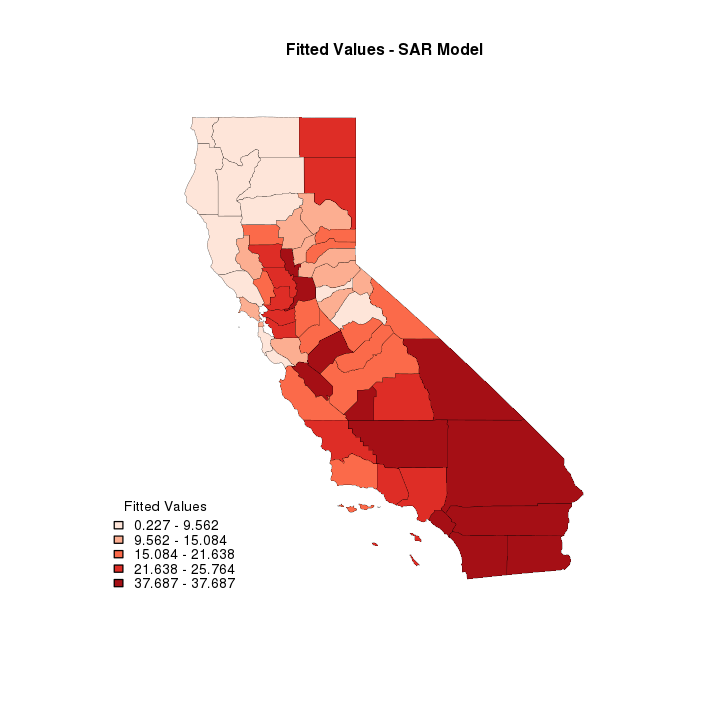

In [17]:
#classify the variable
numcat <- 5
cate <- classIntervals(YVar.sar1$fitted^(1/lambdapwr), numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(inFeaturesSubset, col=cols, lwd=.2,main="Fitted Values - SAR Model",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Fitted Values",cex=.7)

### Examine Correlation Among the Variables

Next, examine the correlation between the dependent and independent variables using the Pearson Correlation Coefficient. This can be done using R's corr() function. As can be observed, the correlation is negative, meaning that as one variable increases, the other decreases. However, given that spatial autocorrelation was detected in the model, this is suspect and can indicated that spatial autocorrelation is affecting the variables themselves. Given this, we can now examine each of the variables for spatial autocorrelation.

In [18]:
#calculate Pearson product moment correlation coefficient
paste("Pearson Correlation = ",cor(y.YVar, EXVar))

[1] "Pearson Correlation =  -0.450420037559126"

## Estimate SAR Model for Each Variable

This time, let's apply a SAR model to both variables (dependent and explanatory) individually and simply examine the impact of the spatial weights. The rho or lambda parameter estimated by the SAR models can then be returned. Note that for both variables, rho (lambda) is significant, indicating spatial autocorrelation is at work in both of the variables.

In [20]:
#estimate SAR autocorrelation parameter for Y variable
YVar.sar2 <- errorsarlm(y.YVar ~ 1, listw=inFeaturesSubset.listw)
summary(YVar.sar2)
paste("Lambda = ",YVar.sar2$lambda)


Call:errorsarlm(formula = y.YVar ~ 1, listw = inFeaturesSubset.listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-2.275816 -0.504825  0.065455  0.802696  1.654604 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept)  2.45312    0.25868  9.4831 < 2.2e-16

Lambda: 0.52368, LR test value: 8.6178, p-value: 0.0033289
Asymptotic standard error: 0.13537
    z-value: 3.8685, p-value: 0.00010951
Wald statistic: 14.965, p-value: 0.00010951

Log likelihood: -80.66485 for error model
ML residual variance (sigma squared): 0.88059, (sigma: 0.9384)
Number of observations: 58 
Number of parameters estimated: 3 
AIC: 167.33, (AIC for lm: 173.95)


[1] "Lambda =  0.523675057739234"

In [21]:
#estimate SAR autocorrelation parameter for X variable
EXVar.sar2 <- errorsarlm(EXVar ~ 1, listw=inFeaturesSubset.listw)
summary(EXVar.sar2)
paste("Lambda = ",EXVar.sar2$lambda)


Call:errorsarlm(formula = EXVar ~ 1, listw = inFeaturesSubset.listw)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.0039  -5.8424  -0.8200   5.3788  46.7737 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept)  36.0551     7.4367  4.8483 1.245e-06

Lambda: 0.82284, LR test value: 46.691, p-value: 8.3095e-12
Asymptotic standard error: 0.069927
    z-value: 11.767, p-value: < 2.22e-16
Wald statistic: 138.46, p-value: < 2.22e-16

Log likelihood: -222.5678 for error model
ML residual variance (sigma squared): 100.68, (sigma: 10.034)
Number of observations: 58 
Number of parameters estimated: 3 
AIC: 451.14, (AIC for lm: 495.83)


[1] "Lambda =  0.822835291462191"

### Adjust Variables for Spatial Autocorrelation

Use the rho (lambda) parameters estimate above to adjust the dependent and explanatory variables for autocorrelation. This task can be accomplished is illustrated below. Basically, the dependent and independent variables are adjusted by subtracting them by the product of rho (lambda) and the spatial weights matrix (as a lag vector). The lag vector can be created using the lag.listw() function (spdep library). After the adjustment is made, re-assess the correlation between the adjusted variables. 

Note that after adjusting for spatial autocorrelation in each variable, the correlation is very much reduced from that computed earlier based on the unadjusted variables. Therefore, it is clear that if spatial autocorrelation was not accounted for, the correlation would appear to be much higher than it actually is.

In [22]:
#adjust for spatial autocorrelation
YVar.sa <- y.YVar - YVar.sar2$lambda * lag.listw(inFeaturesSubset.listw,y.YVar)
EXVar.sa <- EXVar - EXVar.sar2$lambda * lag.listw(inFeaturesSubset.listw,EXVar)

#recompute adjusted Pearson product moment correlation coefficient
cor(YVar.sa,EXVar.sa)

[1] -0.3547806

### Spatially Adjusted OLS

Use the variables adjusted for spatial autocorrelation (YVar.sa and EXVar.sa) in a new OLS model. How do the results differ from the linear model estimated earlier with unadjusted variables?

In [23]:
#apply linear model after adjusting for spatial autocorrelation
YVar.lm.sa <- lm(YVar.sa ~ EXVar.sa)

#summarize model
summary(YVar.lm.sa)


Call:
lm(formula = YVar.sa ~ EXVar.sa)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4057 -0.4592  0.1303  0.6652  1.3494 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.38043    0.13898   9.932 5.84e-14 ***
EXVar.sa    -0.03318    0.01168  -2.840  0.00628 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8929 on 56 degrees of freedom
Multiple R-squared:  0.1259,	Adjusted R-squared:  0.1103 
F-statistic: 8.064 on 1 and 56 DF,  p-value: 0.006283


### Evaluate Adjusted Regression Residuals for Normality

Apply normality diagnostics to test the residuals of the adjusted linear model.

In [24]:
#compute normality diagnostics
shapiro.test(residuals(YVar.lm.sa))


	Shapiro-Wilk normality test

data:  residuals(YVar.lm.sa)
W = 0.95961, p-value = 0.05117


### Evaluate Adjusted Regression Residuals for Spatial Autocorrelation

Test the residuals to see if spatial autocorrelation was effectively treated by the adjustment process.  Well, was it? How can you tell?

In [26]:
#apply moran test to residuals
moran.test(residuals(YVar.lm.sa), inFeaturesSubset.listb)


	Moran I test under randomisation

data:  residuals(YVar.lm.sa)  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = -0.14153, p-value = 0.5563
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.02896141       -0.01754386        0.00650810 
